In [72]:
import pandas as pd
import quandl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import sklearn

import pandas_datareader.data as web

from scipy.optimize import minimize

#Import to install modules
import sys

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.ar_model import AutoReg

from itertools import product
from tqdm import tqdm_notebook

from sklearn import metrics

%matplotlib inline

In [44]:
!{sys.executable} -m pip install pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.2 MB/s eta 0:00:0000:0100:010m


In [56]:
#importing Tesla (TSLA) financial data from quandl
tesla = quandl.get('WIKI/TSLA')

#importing GM (GM) financial data from quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

#importing Apple (APPL) data from quandl
apple = quandl.get('WIKI/AAPL')

#importing Microsoft (MSFT) data from quandl
microsoft = quandl.get('WIKI/MSFT')

print(tesla)

              Open      High     Low   Close      Volume  Ex-Dividend  \
Date                                                                    
2010-06-29   19.00   25.0000   17.54   23.89  18766300.0          0.0   
2010-06-30   25.79   30.4192   23.30   23.83  17187100.0          0.0   
2010-07-01   25.00   25.9200   20.27   21.96   8218800.0          0.0   
2010-07-02   23.00   23.1000   18.71   19.20   5139800.0          0.0   
2010-07-06   20.00   20.0000   15.83   16.11   6866900.0          0.0   
...            ...       ...     ...     ...         ...          ...   
2018-03-21  310.25  322.4400  310.19  316.53   5927881.0          0.0   
2018-03-22  313.89  318.8200  308.18  309.10   4914307.0          0.0   
2018-03-23  311.25  311.6100  300.45  301.54   6600538.0          0.0   
2018-03-26  307.34  307.5900  291.36  304.18   8324639.0          0.0   
2018-03-27  304.00  304.2700  277.18  279.18  13696168.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj

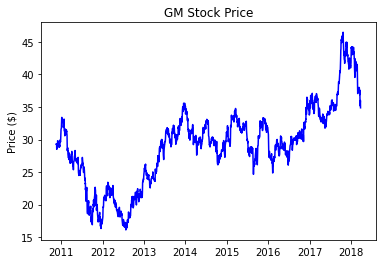

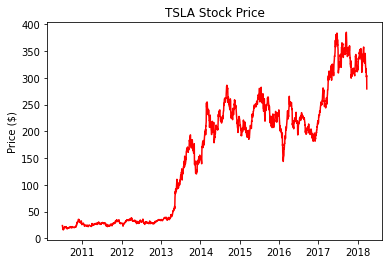

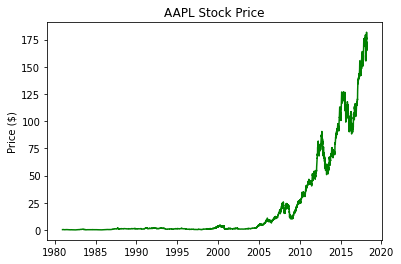

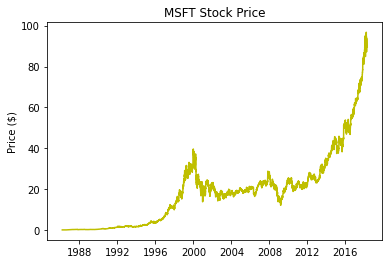

In [30]:
plt.plot(gm.index, gm['Adj. Close'], 'b')
plt.title('GM Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('TSLA Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(apple.index, apple['Adj. Close'], 'g')
plt.title('AAPL Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(microsoft.index, microsoft['Adj. Close'], 'y')
plt.title('MSFT Stock Price')
plt.ylabel('Price ($)')
plt.show()

In [69]:
#yearly average number of shares outstanding for TSLA and GM
#extraced from

#print((0.254+0.461+0.038+0.037)/4)

#print(tesla)

tesla_shares = {
    2018: 0.859e9, 2017: 0.82575e9, 2016: 0.717e9, 2015: 0.63725e9, 2014: 0.6215e9, 
    2013: 0.6295e9, 2012: 0.52875e9, 2011: 0.518e9 , 2010: 0.1975e9}

#gm_shares = {2018:, 2017:, 2016:, 2015:, 2014:, 2013:, 2012:, 2011:, 2010:}

#yearly average number of shars outstanding for AAPL and MSFT

tesla['Year'] = tesla.index.year

print(tesla.index)

tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

#calculate market caps by year
for i, year in enumerate(tesla['Year']):
    shares = tesla_shares.get(year)
    
    tesla.loc[i, 'cap'] = shares*tesla.loc[i, 'Adj. Close']

AttributeError: 'RangeIndex' object has no attribute 'year'

In [70]:
print(type(tesla))

<class 'pandas.core.frame.DataFrame'>


In [72]:
print(tesla.index)

RangeIndex(start=0, stop=1949, step=1)


In [11]:
#The following time series analysis example follows the analysis of mobile game data
#presented here: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

ads = pd.read_csv('/Users/elliotgolias/Documents/QuantFinance/TimeSeriesAnalysis/Data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('/Users/elliotgolias/Documents/QuantFinance/TimeSeriesAnalysis/Data/currency.csv', index_col=['Time'], parse_dates=['Time'])

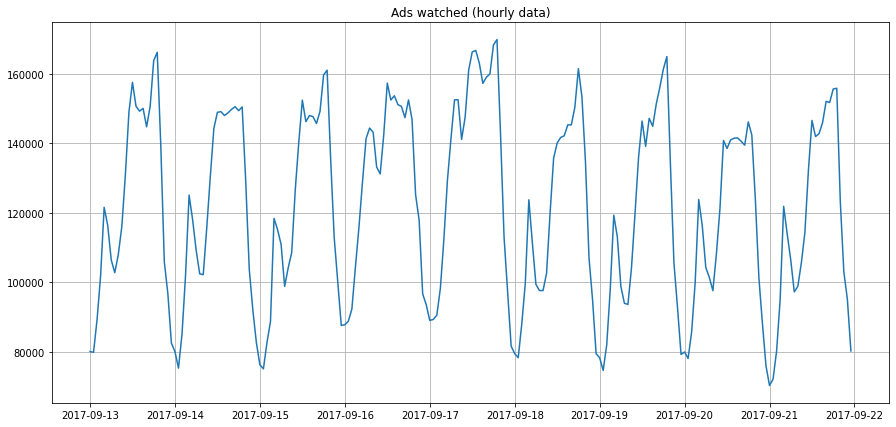

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

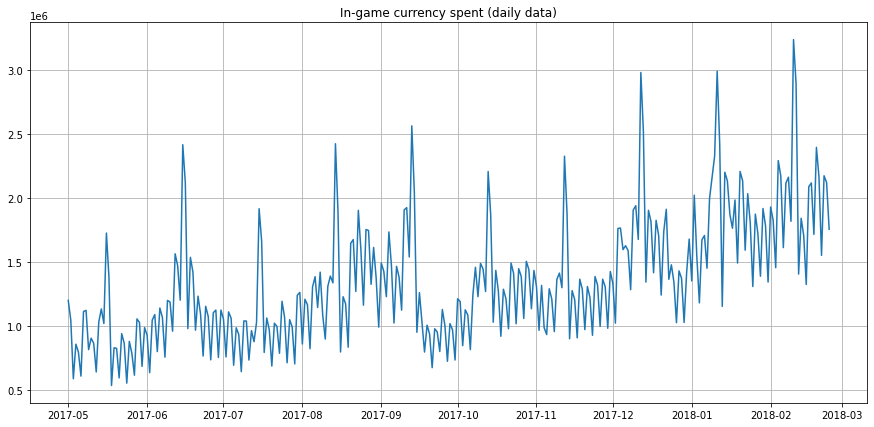

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [13]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24)

116805.0

In [21]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = sklearn.metrics.mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

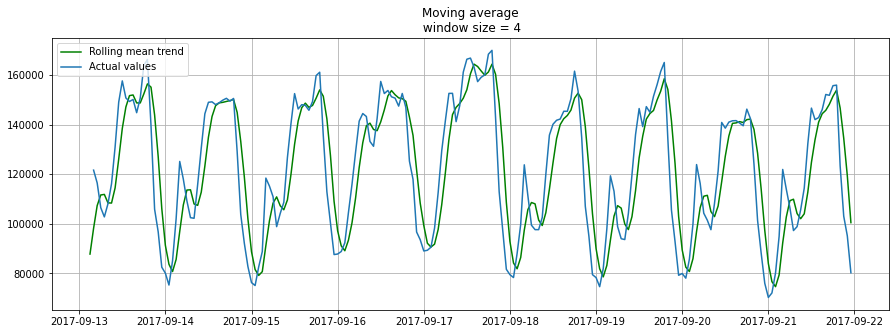

In [17]:
plotMovingAverage(ads, 4) 

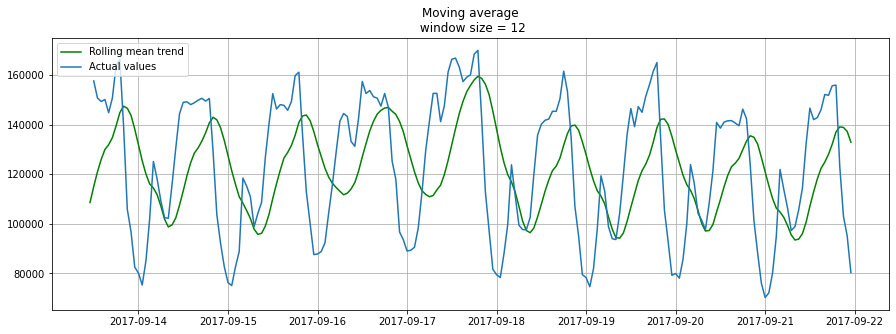

In [18]:
plotMovingAverage(ads, 12)

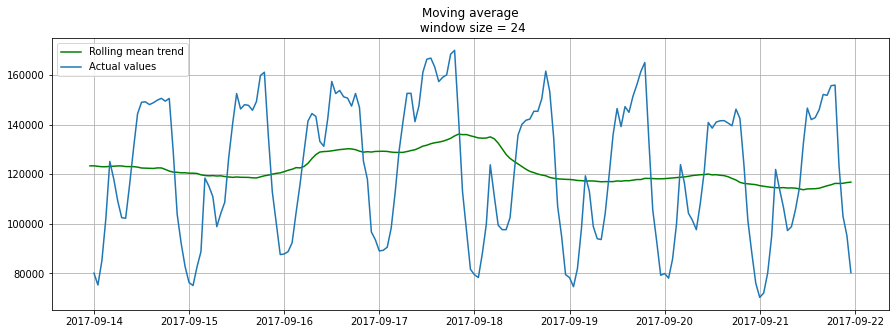

In [19]:
plotMovingAverage(ads, 24)

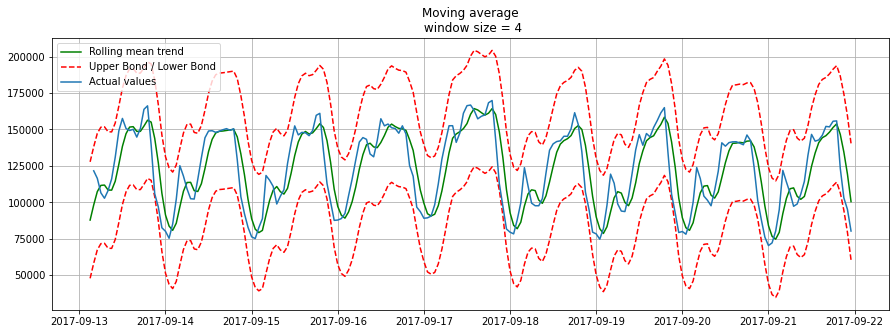

In [30]:
plotMovingAverage(ads, 4, plot_intervals=True)

In [31]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

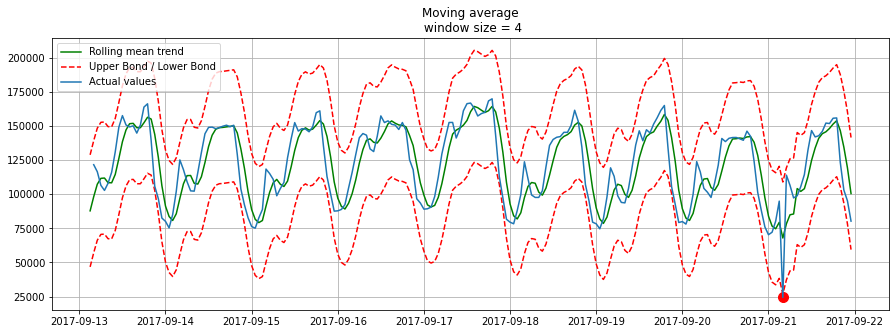

In [32]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

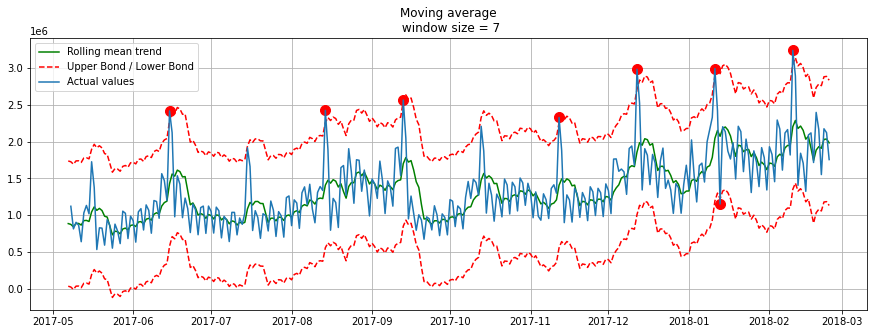

In [33]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

In [48]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [49]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


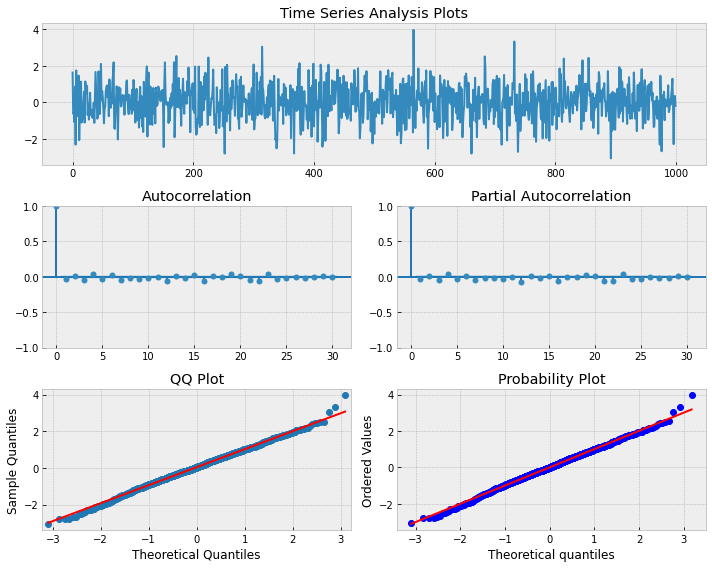

In [50]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


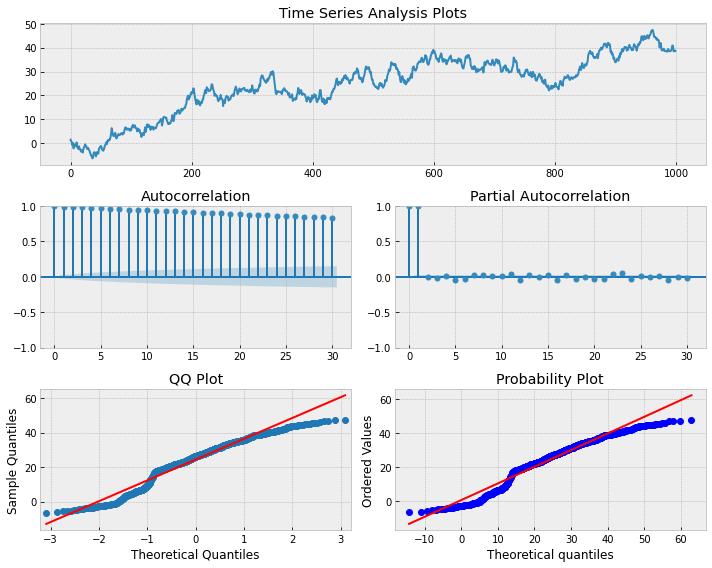

In [51]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


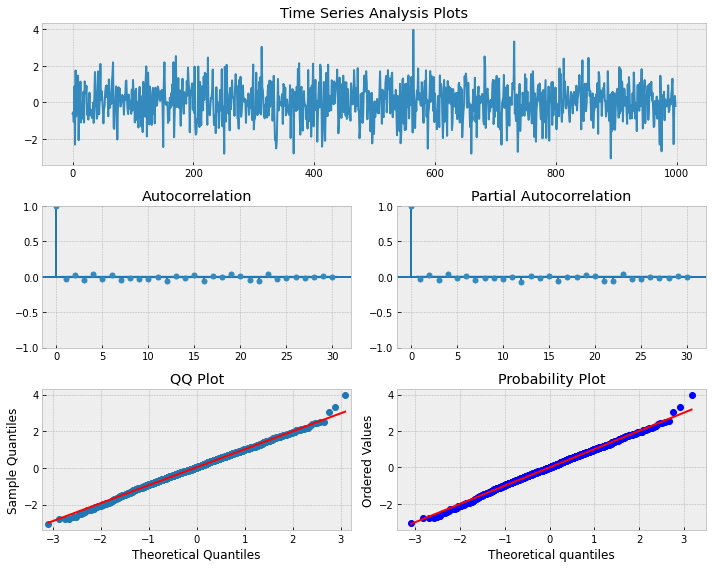

In [52]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


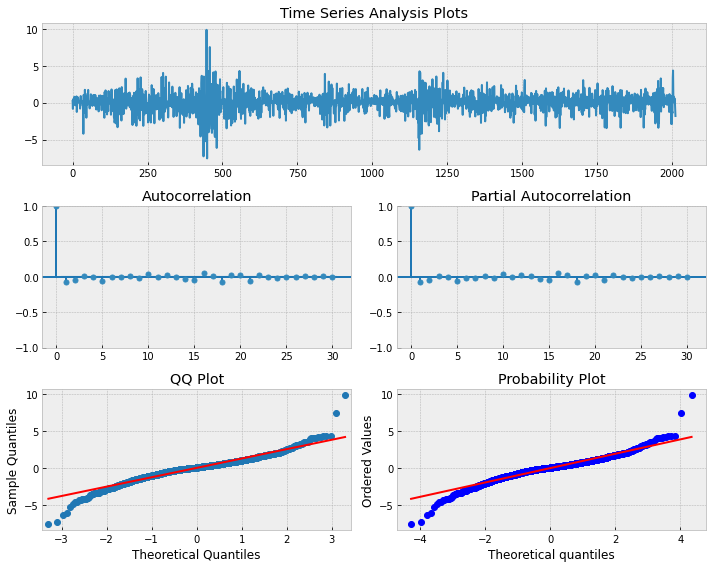

In [53]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


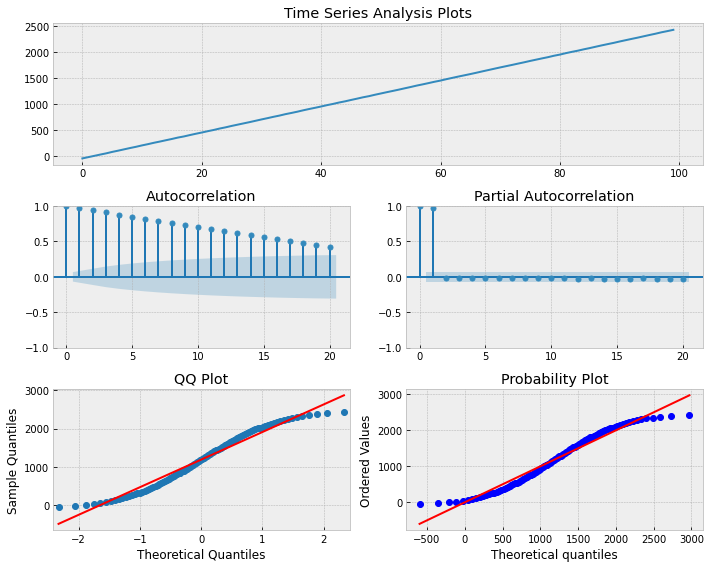

In [67]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=None) 

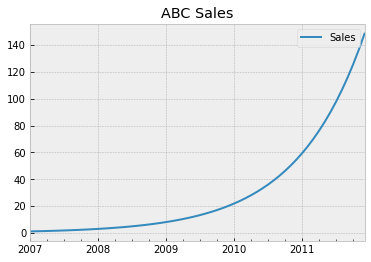

In [55]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

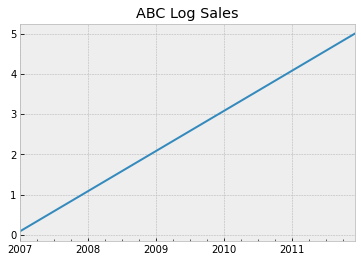

In [56]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


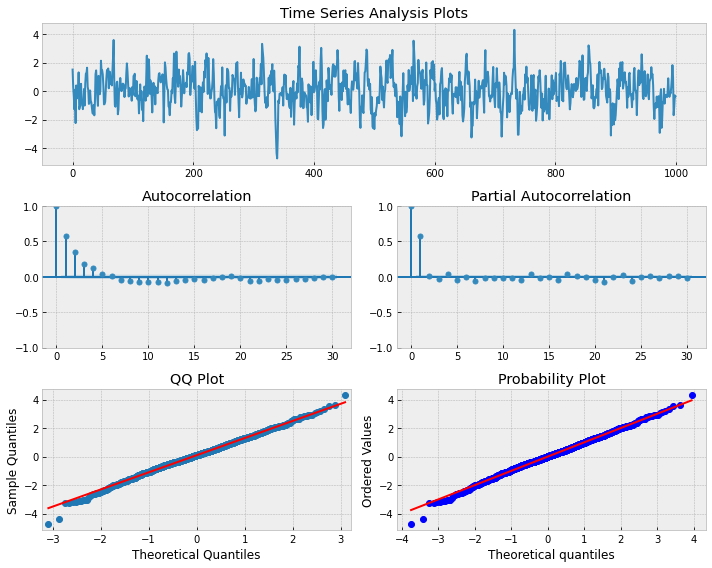

In [68]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=None)

In [78]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AutoReg(x, lags=None, trend='c').fit()
%time est_order = smt.AutoReg(x, lags=None).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

AttributeError: 'AutoReg' object has no attribute 'select_order'

NameError: name 'est_order' is not defined

In [79]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=lags)

NameError: name 'lags' is not defined